# Model to Predict Elo Customer Loyalty

_Note! If you want to commit any changes to this document, please strip all output (Cell > Current Outputs > Clear, or set up [nbstripout](https://github.com/kynan/nbstripout) as a git filter) from this notebook before doing so. Thanks!_


## Import Libraries

Next we import the Python libraries we'll need. If any of these are missing for you, you can install them with e.g. `pip3 install pandas` on the command line.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Load Data

Load the data into Pandas data frames and look at their structure.

First thing we'll do with the training data is split it into a train and validation set. (The given test set is what we'll later make our predictions on and upload, but only after we are fully satisfied with our model.)

In [2]:
hist_trans_df = pd.read_csv('data/unzipped/historical_transactions.csv')
merchants_df = pd.read_csv('data/unzipped/merchants.csv')
merch_trans_df = pd.read_csv('data/unzipped/new_merchant_transactions.csv')
train_and_validation_df = pd.read_csv('data/unzipped/train.csv')
test_df = pd.read_csv('data/unzipped/test.csv')

In [3]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train_and_validation_df, test_size=0.2, random_state=238923)

In [4]:
train_df.shape

(161533, 6)

In [18]:
validate_df.shape

(40384, 6)

In [19]:
hist_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [20]:
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [21]:
merch_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [22]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
47151,2015-06,C_ID_ac2c53f4db,5,1,1,-1.945680
64199,2017-03,C_ID_39fb5ad31f,4,2,0,-1.959972
54956,2017-09,C_ID_a71a9e18ed,3,3,1,-0.573449
190578,2017-10,C_ID_83980a0a9b,3,1,1,-0.530515
49949,2017-12,C_ID_10148fb704,4,1,0,-4.280819


## Explore Data

### Correlations

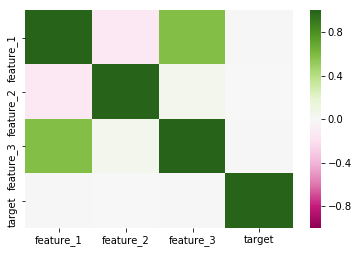

In [23]:
sns.heatmap(train_df.corr(), vmin=-1, vmax=1, cmap='PiYG')

### Distributions

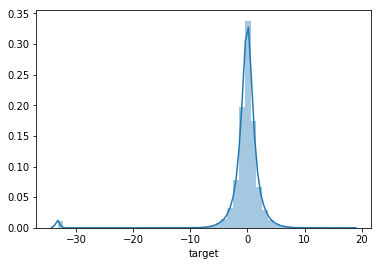

In [24]:
sns.distplot(train_df.target)

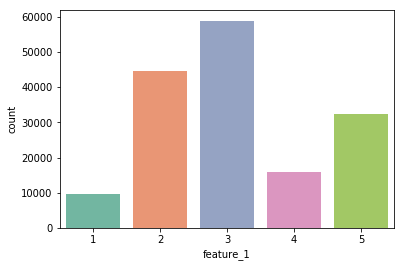

In [25]:
sns.countplot(x='feature_1', palette='Set2', data=train_df)

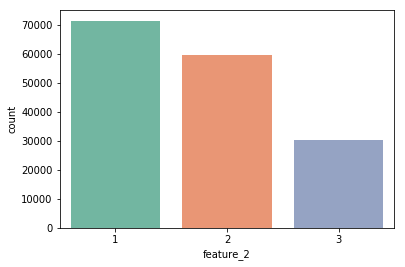

In [26]:
sns.countplot(x='feature_2', palette='Set2', data=train_df)

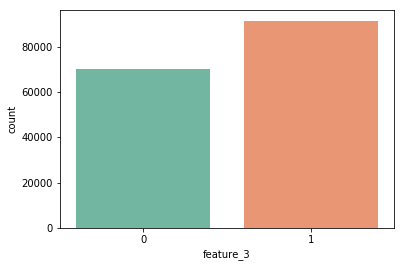

In [27]:
sns.countplot(x='feature_3', palette='Set2', data=train_df)

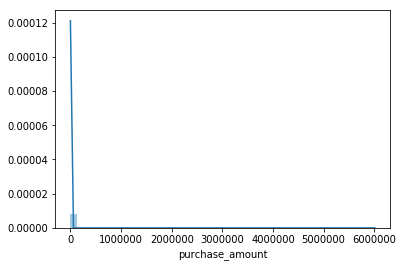

In [28]:
sns.distplot(hist_trans_df.purchase_amount)

## Set Up Model

We'll use the fastai tabular regressor, for which we'll need some additional imports.

In [29]:
from fastai import *
from fastai.tabular import *
from fastai.metrics import *

### Create Data Bunch

A fastai DataBunch more or less contains the data that we'll feed to our model.

First, as the data bunch takes one data frame containing both the test and validation samples, we need to get the indices for our validation samples.

Then we tell the model which of the columns are categorical features, which are continuous features, and also which of the columns contains the target (the value we want to predict).

In [30]:
valid_idx = range(len(train_and_validation_df) - len(validate_df), len(train_and_validation_df))

In [31]:
category_names = ['feature_1', 'feature_2', 'feature_3']
continuous_names = []
dep_var = 'target'

In [32]:
train_df[dep_var].head()

47151    -1.945680
64199    -1.959972
54956    -0.573449
190578   -0.530515
49949    -4.280819
Name: target, dtype: float64

In [33]:
data = (TabularList.from_df(train_and_validation_df,
                            path='data/unzipped',
                            cat_names=category_names,
                            cont_names=continuous_names,
                            procs=[FillMissing, Categorify, Normalize])
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

### Create Learner

This is what we actually use to train the model and make predictions.

First we decide how large we want to make the embeddings of our categorical features (the number of category options divided by 2 is a good heuristic, apparently).

Then we tell the model the range within which we expect all predictions to fall (internally the model uses a sigmoid function, so in order for us, in practice, to actually get predictions near the expected maximum value, we set the upper bound to be a little higher than the expected maximum).

The competition uses root mean squared error to evaluate the entries, so we'll use that, too. _(Note: I didn't get it to work yet with RMSE, so we will use exponential root mean squared error, which works, until then.)_

In [34]:
category_szs = {'feature_1': 5,
                'feature_2': 3,
                'feature_3': 2}
emb_szs = {k: (v + 1) // 2 for k, v in category_szs.items()}

In [35]:
max_log_y = np.log(np.max(train_df['target']) * 1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [36]:
def rmse(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Root mean squared error between `pred` and `targ`."
    return torch.sqrt(F.mse_loss(pred, targ))

In [37]:
learn = tabular_learner(data,
                        layers=[1000, 500],
                        emb_szs=emb_szs,
                        ps=[0.2, 0.5],
                        emb_drop=0.1,
                        y_range=y_range,
                        metrics=rmse)

In [38]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(4, 2)
    (2): Embedding(3, 1)
  )
  (emb_drop): Dropout(p=0.1)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

### Figure Out Learning Rate

To figure out which learning rate to use, we use fastai's learning rate finder.

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


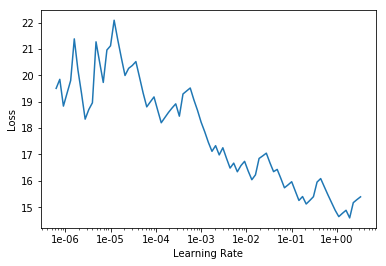

In [40]:
learn.recorder.plot()

### Train Model

Finally we train the model, with weight decay to encourage the model to use fewer features, and then show some results.

In [ ]:
learn.fit_one_cycle(1, 1e-5, wd=0.2)

epoch,train_loss,valid_loss,rmse


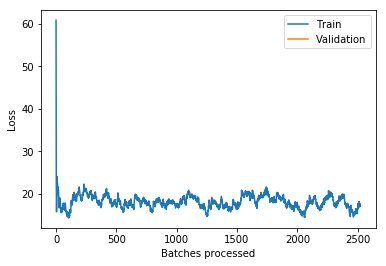

In [30]:
learn.recorder.plot_losses()